* By: Illya Barziy
* Email: illyabarziy@gmail.com
* Reference: Advances in Financial Machine Learning, Chapter-14

## Chapter 14 Backtest Statistics

## Introduction

Whenever a strategy is created, it's performance has to be tested and reported. This chapter covers some of the statistics that are used for understanding the characteristics of a strategy related to levels of risk and return. It also provides tools to test if the strategy satisfies desired profitability benchmarks (Sharpe ratio in particular). Statistics in this chapter cover the following topics:
- Drawdown
- Time under water
- Herfindahl-Hirschman Index or Concentration of returns
- Sharpe ratio
- Probabilistic Sharpe ratio
- Deflated Sharpe ratio

In this notebook, the exercises from Chapter-14 in the book "Advances in Financial Machine Learning" are implemented.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import mlfinlab as ml

## Question-14.1

### A strategy exhibits a high turnover, high leverage, and high number of bets, with a short holding period, low return on execution costs, and a high Sharpe ratio. Is it likely to have large capacity? What kind of strategy do you think it is?

Looking closer to the characteristics:
- A high turnover means that the average amount traded per year is higher than the average annual amount of Assets Under Management (AUM). This situation indicates that the positions are often changed - tuned or flipped.  
- High leverage means that the amounts borrowed for strategy execution are high compared to the AUM.
- The high number of bets occurs when positions are changed frequently. It shows that the strategy certainly doesn't have long holding periods.
- Short holding periods go in line with the previous characteristic.
- low return on execution cases - when the ratio between dollar performance (including brokerage fees and slippage costs) and total execution costs is low, there are high chances that strategy won't survive worse-than-expected execution.
- The high Sharpe ratio shows that returns are high and have a relatively low level of volatility.

Capacity is defined as the highest AUM that delivers a target risk-adjusted performance. Since the strategy shows high leverage, it isn't likely to have high capacity since a big portion of resources is borrowed.

The strategy described above may be either a statistical arbitrage or an intraday trading strategy.

## Question-14.2

### On the dollar bars dataset for E-mini S&P 500 futures, compute
### (a) HHI index on positive returns

#### !!!Note that this notebook uses a full dataset. If one tries to run the notebook on sample data provided in the GitHub repository the results will be different!!!

#### We use log returns in the examples below

We assume no transaction costs and the amount invested is the first observed price of a contract

In [3]:
#Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [4]:
data

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499
...,...,...,...,...,...,...,...
2019-02-01 20:55:01.064,2704.00,2704.00,2700.75,2702.50,25921,70045841.00,4040
2019-02-01 20:59:21.030,2702.50,2705.00,2702.50,2704.75,25890,70006624.75,4172
2019-02-01 20:59:59.015,2704.75,2706.00,2704.50,2704.50,25895,70050302.25,2596


In [5]:
#Transforming data to log returns from one long position
logret_series = np.log(data['close']).diff()[1:]

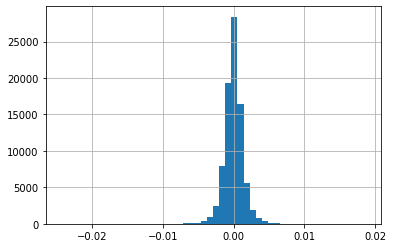

In [6]:
logret_series.hist(bins=50)
plt.show()

In [7]:
#Using mlfinlab package function for detailed concentration output
pos_concentr, neg_concentr, hourly_concentr = ml.backtest_statistics.all_bets_concentration(logret_series, frequency='H')

In [8]:
print('HHI index on positive log returns is' , pos_concentr)

HHI index on positive log returns is 2.5930058463712052e-05


Concentration (or HHI index) on positive log returns is fairly close to zero. From its properties, we can conclude that the log returns distribution is likely to have no fat right tail.

### (b) HHI index on negative returns

In [9]:
print('HHI index on negative log returns is' , neg_concentr)

HHI index on negative log returns is 2.4569679802262173e-05


Concentration (or HHI index) on negative log returns is fairly close to zero, the same as for positive ones. From its properties, we can conclude that the log returns distribution is likely to have no fat left tail.

### (c) HHI index on time between bars

In [10]:
print('HHI index on log returns divided into hourly bins is' , hourly_concentr)

HHI index on log returns divided into hourly bins is 5.438411110913481e-05


Concentration (or HHI index) on time between bars (from the observed dataset, roughly 1h between bars) is low. This means bets are not concentrated in time or are close to being uniformly distributed across time.

### (d) The 95-percentile DD

In [11]:
#Getting series of prices to represent the value of one long portfolio
price_series = data['close'][1:]

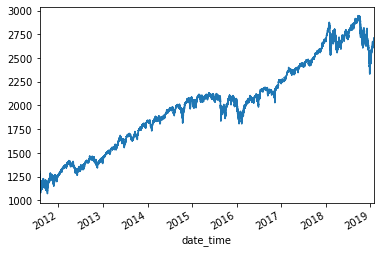

In [12]:
#Looking at the performance of a protfolio
price_series.plot()
plt.show()

In [13]:
#Using mlfinlab package function to get drawdowns and time under water series
drawdown, tuw = ml.backtest_statistics.drawdown_and_time_under_water(price_series, dollars = False)
drawdown_dollars, _ = ml.backtest_statistics.drawdown_and_time_under_water(price_series, dollars = True)

In [14]:
print('The 95th percentile of Drawdown is' , drawdown.quantile(.95))

The 95th percentile of Drawdown is 0.01769512497257557


In [15]:
print('The 95th percentile of Drawdown in dollars is' , drawdown_dollars.quantile(.95))

The 95th percentile of Drawdown in dollars is 34.912499999999966


This means that from the observed set, 95% of drawdowns are below 0.018 or 1.8% of the portfolio (If assuming long position). In the dollar equivalent, it is $34.91.

### (e) The 95-percentile TuW

In [16]:
print('The 95th percentile of Time under water' , tuw.quantile(.95))

The 95th percentile of Time under water 0.031676884150598425


From the results, 95% of the time under water is below 0.0317 years, or 7.98 trading days.

### (f) Annualized average return

We use the formula:

$AnnualizedAverageReturn = \frac{EndingValue}{BeginningValue}^{\frac{1}{Years}}-1 $

In [17]:
#Using simple formula for annual return calculation
days_observed = (price_series.index[-1] - price_series.index[0]) / np.timedelta64(1, 'D')
cumulated_return = price_series[-1]/price_series[0]

#Using 365 days instead of 252 as days observed are calculated as calendar
#days between the first observation and the last
annual_return = (cumulated_return)**(365/days_observed) - 1

In [18]:
print('Annualized average return from the portfolio is' , annual_return)

Annualized average return from the portfolio is 0.10169027020627053


So, the average annual return from the given data is 10.169%

### (g) Average returns from hits (positive returns)

In [19]:
print('Average log return from positive bars is' , logret_series[logret_series>0].mean(), 
      'and counter is', logret_series[logret_series>0].count())

#Also looking at returns grouped by days
logret_by_days = logret_series.groupby(pd.Grouper(freq='D')).sum()
logret_by_days = logret_by_days[logret_by_days!=0]
print('Average log return from positive bars grouped by days is' , 
      logret_by_days[logret_by_days>0].mean(), 'and counter is', 
      logret_by_days[logret_by_days>0].count())

Average log return from positive bars is 0.00099482493140664 and counter is 41280
Average log return from positive bars grouped by days is 0.005951808843591273 and counter is 1117


Average log return from bar hits is 0.00099 and from day hits 0.00595. Hits from bars are 37 times more frequent than daily hits.

### (h) Average return from misses (negative returns)

In [20]:
print('Average log return from negative bars is' , logret_series[logret_series<0].mean(),
     'and counter is', logret_series[logret_series<0].count())

print('Average log return from negative bars grouped by days is' , 
      logret_by_days[logret_by_days<0].mean(), 'and counter is',
      logret_by_days[logret_by_days<0].count())

Average log return from negative bars is -0.0010137295473279077 and counter is 39792
Average log return from negative bars grouped by days is -0.006225156106306478 and counter is 951


Average log return from bar misses is -0.101% and from day hits -0.623%. The number of misses is just slightly (3.6%) lower than the number of hits.

### (i) Annualized SR

$AnnualizedSR = \frac{Mean(Returns)}{StandardDeviation(Returns)}*\sqrt{ReturnsObservedPerYear}$

In [21]:
#Uning mlfinlab package function to get SR
annualized_sr = ml.backtest_statistics.sharpe_ratio(logret_by_days, entries_per_year=252, risk_free_rate=0)
print('Annualized Sharpe Ratio is' , annualized_sr)

Annualized Sharpe Ratio is 0.6207628576848087


The annualized Sharpe ratio for the long position on the portfolio is fairly low at 0.62.

### (j) Information ratio, where the benchmark is the risk-free rate

Information ratio is the annualized ratio between the average excess return and the tracking error. The excess return is measured as the portfolio’s return in excess of the benchmark’s return. The tracking error is estimated as the standard deviation of the excess returns.

$InformationRatio = \frac{Mean(Returns - Benchmark)}{StandardDeviation(Returns - Benchmark)}*\sqrt{ReturnsObservedPerYear}$

For the benchmark, let's assume the risk-free rate to be the 10-year treasury rate at the beginning of 2020 at 1.8% per year

In [22]:
#Stating the risk-free ratio and trading days per year
risk_free_ratio = 0.018
trading_days = 252

#Calculating excess returns above the risk-free ratio
#This means subtracting the benchmark from daily returns

#Daily returns adjusted for taking compounding effect into account
daily_risk_free_ratio = (1 + risk_free_ratio)**(1/trading_days) - 1
log_daily_risk_free_ratio = np.log(1 + daily_risk_free_ratio)

#Using mlfinlab package function to get Information ratio
information_ratio = ml.backtest_statistics.information_ratio(logret_by_days, 
                       log_daily_risk_free_ratio, entries_per_year=trading_days)

print('Information ratio (with yearly risk-free rate assumed to be 1.8%) is' , information_ratio)

Information ratio (with yearly risk-free rate assumed to be 1.8%) is 0.4959356818028273


Information ratio is the Sharpe ratio equivalent of a portfolio that measures its performance relative to a benchmark. It is lower than the Sharpe ratio, as expected, as we're measuring the relative performance of a portfolio. It is still positive, which means that the portfolio outperforms the benchmark of a risk-free rate.

### (k) PSR

The Probabilistic Sharpe ratio (PSR) provides an adjusted estimate of SR, by removing the inflationary effect caused by short series with skewed and/or fat-tailed returns.

As no benchmark Sharpe ratio is provided, let's assume it to be at 0.6, a bit lower than the previously calculated Annual SR.

In [23]:
#Using mlfinlab package function to get PSR
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                                     benchmark_sr=0.6, 
                                                                     number_of_returns=days_observed, 
                                                                     skewness_of_returns=logret_by_days.skew(), 
                                                                     kurtosis_of_returns=logret_by_days.kurt())
print('Probabilistic Sharpe Ratio with benchmark SR of 0.6 is' , probabilistic_sr)

Probabilistic Sharpe Ratio with benchmark SR of 0.6 is 0.7990555934340262


As the PSR value is lower than 0.95, we have to reject the hypothesis that the Sharpe ratio is 0.6 for the 5% significance level.

In [24]:
probabilistic_sr_adj = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                                         benchmark_sr=0.58, 
                                                                         number_of_returns=days_observed, 
                                                                         skewness_of_returns=logret_by_days.skew(), 
                                                                         kurtosis_of_returns=logret_by_days.kurt())
print('Probabilistic Sharpe Ratio with benchmark SR of 0.58 is' , probabilistic_sr_adj)

Probabilistic Sharpe Ratio with benchmark SR of 0.58 is 0.9500879214252643


However, with the benchmark SR of 0.58, the PSR is just above 0.95. So, we can assume Sharpe ratio to be 0.58 for the 5% significance level.

### (l) DSR, where we assume there were 100 trials, and the variance of the trials’ SR was 0.5

Deflated Sharpe Ratio (DSR) is a PSR where the rejection threshold is adjusted to reflect the multiplicity of trials. DSR is estimated as PSR[SR∗], where the benchmark Sharpe ratio, SR∗, is no longer user-defined but calculated from SR estimate trails.

In [25]:
#Using mlfinlab package function to get DSR. Passing standard deviation of trails and
#number of trails as a parameter, also flag estimates_param.
deflated_sr = ml.backtest_statistics.deflated_sharpe_ratio(observed_sr=annualized_sr, 
                                                           sr_estimates=[0.5**(1/2), 100], 
                                                           number_of_returns=days_observed, 
                                                           skewness_of_returns=logret_by_days.skew(), 
                                                           kurtosis_of_returns=logret_by_days.kurt(),
                                                           estimates_param=True)
print('Deflated Sharpe Ratio with 100 trails and 0.5 variance is' , deflated_sr)

Deflated Sharpe Ratio with 100 trails and 0.5 variance is 0.0


The Deflated Sharpe ratio is extremely low. This is because the benchmark in the estimate is set high:

In [26]:
#DSR function also allows the output of benchmark SR calculated when benchmark_out 
#flag is set to True.
benchmark_sr_dsr = ml.backtest_statistics.deflated_sharpe_ratio(observed_sr=annualized_sr, 
                                                                sr_estimates=[0.5**(1/2), 100], 
                                                                number_of_returns=days_observed, 
                                                                skewness_of_returns=logret_by_days.skew(), 
                                                                kurtosis_of_returns=logret_by_days.kurt(),
                                                                estimates_param=True, benchmark_out=True)

print('Benchmark Sharpe ratio used in DSR is' , benchmark_sr_dsr)

Benchmark Sharpe ratio used in DSR is 1.7894064662732079


If the number of trails was smaller, the results would be different:

In [27]:
benchmark_sr_dsr_adj = ml.backtest_statistics.deflated_sharpe_ratio(observed_sr=annualized_sr, 
                                                                    sr_estimates=[0.5**(1/2), 3], 
                                                                    number_of_returns=days_observed, 
                                                                    skewness_of_returns=logret_by_days.skew(), 
                                                                    kurtosis_of_returns=logret_by_days.kurt(),
                                                                    estimates_param=True, benchmark_out=True)

print('Benchmark Sharpe ratio if number of trails is decreased to 3 is' , benchmark_sr_dsr_adj)

deflated_sr = ml.backtest_statistics.deflated_sharpe_ratio(observed_sr=annualized_sr, 
                                                           sr_estimates=[0.5**(1/2), 3], 
                                                           number_of_returns=days_observed, 
                                                           skewness_of_returns=logret_by_days.skew(), 
                                                           kurtosis_of_returns=logret_by_days.kurt(),
                                                           estimates_param=True)
print('Deflated Sharpe Ratio with 3 trails and 0.5 variance is' , deflated_sr)

Benchmark Sharpe ratio if number of trails is decreased to 3 is 0.6030238422545333
Deflated Sharpe Ratio with 3 trails and 0.5 variance is 0.7630574203326299


## Question-14.3

### Consider a strategy that is long one futures contract on even years, and is short one futures contract on odd years.

### (a) Repeat the calculations from exercise 2

We assume no transaction costs and the amount invested is the first observed price of a contract

In [28]:
#To change the existing series of returns from one long position to the one 
#described above, we multiply odd years log returns by -1.
logret_series_with_short = logret_series *(1 - 2 * (logret_series.index.year % 2))

#Portfolio prices are calculated by reversing the log returns to cumulated sum
#of normal returns series and multiplying them by the price of a contract
price_series_with_short = price_series[0] * np.exp(logret_series_with_short.cumsum()) 

### _Distribution of returns_

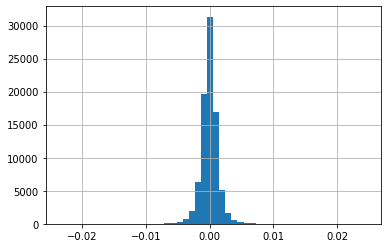

In [29]:
logret_series_with_short.hist(bins=50)
plt.show()

On the histogram of log returns looks about the same as the previous one

### _Positive, negative and time concentrations (or HHI)_

In [30]:
pos_concentr, neg_concentr, hourly_concentr = ml.backtest_statistics.all_bets_concentration(logret_series_with_short, frequency='H')
print('HHI index of positive log returns is' , pos_concentr)
print('HHI index of negative log returns is' , neg_concentr)
print('HHI index of log returns divided by hourly bins is' , hourly_concentr)

HHI index of positive log returns is 2.670439671024535e-05
HHI index of negative log returns is 2.388044051983817e-05
HHI index of log returns divided by hourly bins is 5.438411110913481e-05


The concentration of positive log returns has slightly increased, while the concentration of negative has decreased. This would mean that the distribution is now less likely to have a left fat tail and more likely to have a fat right tail.

Concentration in time is exactly the same, as the returns occur with the same frequency as in the previous portfolio.

### _Drawdown and Time under water 95th percentile_

In [31]:
#Using mlfinlab package function to get drawdowns and time under water series
drawdown, tuw = ml.backtest_statistics.drawdown_and_time_under_water(price_series_with_short, dollars = False)
drawdown_dollars, _ = ml.backtest_statistics.drawdown_and_time_under_water(price_series_with_short, dollars = True)

In [32]:
print('The 95th percentile of Drawdown is' , drawdown.quantile(.95))

The 95th percentile of Drawdown is 0.10633765341973031


In [33]:
print('The 95th percentile of Drawdown in dollars is' , drawdown_dollars.quantile(.95))

The 95th percentile of Drawdown in dollars is 167.4492843785195


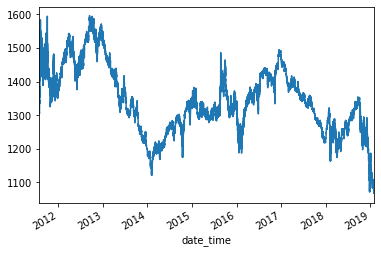

In [34]:
price_series_with_short.plot()
plt.show()

The results show that the 95th Drawdown percentile is 0.106. However, the portfolio from the starting value of 1305.75 decreased up to 1070.93 (almost -18%). Why is that?

It's because we had many small drawdowns in the period of 2011.08-2012.09. In 2012.09 a peak of portfolio value is observed. Since that time, there was one big drawdown up till the last day. Therefore, quantile measure here is not informative, as we have a set of small drawdowns and a 1 huge outlier at the end of the time period.

In [35]:
print('Maximum Drawdown is', max(drawdown))

Maximum Drawdown is 0.3315840502520586


The same situation is observed with the Time under water. Mlfinlab function also includes time between the last high watermark and last observation in returns as the last Time under water element (even though it's not time between two high watermarks). Without this element the estimations of Time under water can be biased. It's clearly seen in our example, where the last Time under water over 6 years.

In [36]:
print('The 95th percentile of Time under water' , tuw.quantile(.95))

The 95th percentile of Time under water 0.12496082496813973


In [37]:
print('Maximum Time under water is', max(tuw))

Maximum Time under water is 6.382838106544638


### _Annualized average return_

In [38]:
cumulated_return_with_short = price_series_with_short[-1]/price_series_with_short[0]
annual_return = (cumulated_return_with_short)**(365/days_observed) - 1

In [39]:
print('Annualized average return from the portfolio is' , annual_return)

Annualized average return from the portfolio is -0.026046796015894658


The average annual return is negative. It is expected after we saw the plot of portfolio value.

### _Average returns from hits (positive returns)_

In [40]:
print('Average log return from positive bars in is' , 
      logret_series_with_short[logret_series_with_short>0].mean(), 
      'and counter is', 
      logret_series_with_short[logret_series_with_short>0].count())

#Also looking at results grouped by days
logret_by_days = logret_series_with_short.groupby(pd.Grouper(freq='D')).sum()
logret_by_days = logret_by_days[logret_by_days!=0]
print('Average log return from positive bars grouped by days is' , 
      logret_by_days[logret_by_days>0].mean(), 'and counter is', 
      logret_by_days[logret_by_days>0].count())

Average log return from positive bars in is 0.0010041532928493889 and counter is 40435
Average log return from positive bars grouped by days is 0.006016279869835005 and counter is 1028


Comparing to the previous portfolio, we have on average higher daily returns from hits (0.00601 vs 0.00595 earlier), but the counter is much lower (1028 vs 1117 earlier).

### _Average returns from misses (negative returns)_

In [41]:
print('Average return from negative bars is',
      logret_series_with_short[logret_series_with_short<0].mean(),       
     'and counter is', 
      logret_series_with_short[logret_series_with_short<0].count())

print('Average return from negative bars grouped by days is' , 
      logret_by_days[logret_by_days<0].mean(), 'and counter is',
      logret_by_days[logret_by_days<0].count())

Average return from negative bars is -0.0010040544557760951 and counter is 40637
Average return from negative bars grouped by days is -0.006138036758844737 and counter is 1040


Comparing to the previous portfolio, we have on average lower daily log returns (in absolute terms) from hits (-0.00613 vs -0.00622 earlier), but the counter is much higher (1040 vs 951 earlier).

### _Annualized SR_

In [42]:
#Using mlfinlab package function to get SR
annualized_sr = ml.backtest_statistics.sharpe_ratio(logret_by_days, entries_per_year=252, risk_free_rate=0)
print('Annualized Sharpe Ratio is' , annualized_sr)

Annualized Sharpe Ratio is -0.16940438831937363


It is expected for the Sharpe ratio to be negative, as the strategy generated a loss.

Testing for Information ratio makes no sense in this situation, as it will show even lower values compared to the Annualized SR.

PSR and DSR calculations make no sense when the Annualized Sharpe ratio is below zero, as it will be smaller than any positive benchmark SR.

### (b) What is the correlation to the underlying?

The obtained results show that on average, E-mini S&P 500 futures were growing in price. Therefore going each odd year short resulted in negative returns, because of the big growth in price in the year 2019.

## Question-14.4

### The results from a 2-year backtest are that monthly returns have a mean of 3.6%, and a standard deviation of 0.079%.

### (a) What is the SR?

Simple Sharpe ratio is calculated as:

$SR=\frac{E[r]}{\sqrt{V[r]}}$, where $r$ - monthly returns.

So, $SR = \frac{3.6}{0.079} = 45.57$

It's so high due to the standard deviation being so low. This means that 99.7% of returns fall in the (3.363%;3.837%) range. If we use the risk-free rate in the calculation, say 1.8%, then:

$SR=\frac{E[r]-R_f}{\sqrt{V[r]}}$, where $r$ - monthly returns, $R_f$ - risk-free rate

So, $SR = \frac{3.6-1.8}{0.079} = 22.78$

This SR is lower, however still high, as the standard deviation is the same.

### (b) What is the annualized SR?

Annualized Sharpe ratio is calculated as:

$SR=\frac{E[r]}{\sqrt{V[r]}}*\sqrt{N}$, where $r$ - monthly returns, $N$ - number of observations per year.

So, $SR = \frac{3.6}{0.079}*\sqrt{12} = 157.86$


## Question-14.4

### Following on exercise 1:
### (a) The returns have a skewness of 0 and a kurtosis of 3. What is the PSR?

We assume it to be a typo, and that the question relates to 14.4 instead of 14.1, as the latter gives no details on exact Sharpe ratio or the number of observed returns.

From a theoretical perspective, PSR corrects SR for inflationary effects caused by non-Normal returns. The skewness of 0 and kurtosis of 3 show that returns are normal.

Using the PSR formula:

$PSR[SR*] = Z[\frac{(SR - SR*)\sqrt{T-1}}{\sqrt{1-\gamma_3SR+\frac{\gamma_4-1}{4}SR^2}}]$

With SR 45 as a benchmark, 

$PSR[45] = Z[\frac{(45.57-45)\sqrt{24-1}}{\sqrt{1-0*45.57+\frac{3-1}{4}45.57^2}}] = 0.5338 $

So, at 5% significance level, we reject that Sharpe ratio is higher than the benchmark 45 SR. Upon decreasing the benchmark:

$PSR[34] = Z[\frac{(45.57-34)\sqrt{24-1}}{\sqrt{1-0*45.57+\frac{3-1}{4}45.57^2}}] = 0.9574 $

So, at 5% significance level, Sharpe ratio is higher than the benchmark 34 SR. 


In [43]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=45, 
                                                                     number_of_returns=24, 
                                                                     skewness_of_returns=0, 
                                                                     kurtosis_of_returns=3)
print('Probabilistic Sharpe Ratio with 45 SR benchmark is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 45 SR benchmark is 0.5337874636475838


In [44]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=34, 
                                                                     number_of_returns=24, 
                                                                     skewness_of_returns=0, 
                                                                     kurtosis_of_returns=3)
print('Probabilistic Sharpe Ratio with 34 SR benchmark is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 34 SR benchmark is 0.9573901697590402


### _Looking into relations between PSR and the number of observations_

If the same skewness and kurtosis observed in a bigger set of observations, the PSR increases. The example below shows that for a benchmark SR of 40:

In [45]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=40, 
                                                                     number_of_returns=24, 
                                                                     skewness_of_returns=0, 
                                                                     kurtosis_of_returns=3)
print('Probabilistic Sharpe Ratio with 40 SR benchmark and 24 observations is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 40 SR benchmark and 24 observations is 0.7963352104207573


In [46]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=40, 
                                                                     number_of_returns=240, 
                                                                     skewness_of_returns=0, 
                                                                     kurtosis_of_returns=3)
print('Probabilistic Sharpe Ratio with 40 SR benchmark and 240 observations is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 40 SR benchmark and 240 observations is 0.9962192159601215


### (b) The returns have a skewness of -2.448 and a kurtosis of 10.164. What is the PSR?

### _Looking into relations between PSR and skewness/kurtosis of returns_

Using the PSR formula with SR 45 as a benchmark, 

$PSR[45] = Z[\frac{(45.57-45)\sqrt{24-1}}{\sqrt{1-(-2.448)*45.57+\frac{10.164-1}{4}45.57^2}}] = 0.5156 $

So, we can see that PSR decreased comparing to the PSR of returns with skewness of 0 and kurtosis of 3.
As seen from these examples, both the decrease of skewness and increase of kurtosis result in smaller PSR :

$PSR[45](skew=0, kurt=3) = Z[\frac{(45.57-45)\sqrt{24-1}}{\sqrt{1-(0)*45.57+\frac{3-1}{4}45.57^2}}] = 0.5338 $

$PSR[45](skew=-2.448, kurt=3) = Z[\frac{(45.57-45)\sqrt{24-1}}{\sqrt{1-(-2.448)*45.57+\frac{3-1}{4}45.57^2}}] = 0.5321 $

$PSR[45](skew=0, kurt=10.164) = Z[\frac{(45.57-45)\sqrt{24-1}}{\sqrt{1-(0)*45.57+\frac{10.164-1}{4}45.57^2}}] = 0.5158 $


In [47]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=45, 
                                                                     number_of_returns=24, 
                                                                     skewness_of_returns=-2.448, 
                                                                     kurtosis_of_returns=3)
print('Probabilistic Sharpe Ratio with 45 SR benchmark (skew=-2.448, kurt=3) is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 45 SR benchmark (skew=-2.448, kurt=3) is 0.5321119245830213


In [48]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=45, 
                                                                     number_of_returns=24, 
                                                                     skewness_of_returns=0, 
                                                                     kurtosis_of_returns=10.164)
print('Probabilistic Sharpe Ratio with 45 SR benchmark (skew=0, kurt=10.164) is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 45 SR benchmark (skew=0, kurt=10.164) is 0.5158051263800146


In [49]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=45, 
                                                                     number_of_returns=24, 
                                                                     skewness_of_returns=-2.448, 
                                                                     kurtosis_of_returns=10.164)
print('Probabilistic Sharpe Ratio with 45 SR benchmark (skew=-2.448, kurt=10.164) is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 45 SR benchmark (skew=-2.448, kurt=10.164) is 0.5156231539970734


## Question-14.6

### What would be the PSR from 2.b, if the backtest had been for a length of 3 years?

We assume it to be a typo, and that the question relates to 14.5.b instead of 14.2.b, as the latter doesn't calculate PSR.

Using the PSR formula with SR 45 as a benchmark, 

$PSR[45] = Z[\frac{(45.57-45)\sqrt{36-1}}{\sqrt{1-(-2.448)*45.57+\frac{10.164-1}{4}45.57^2}}] = 0.5192 $

So, we can see that PSR has increased when comparing to PSR from the sample of 24 observations (it was 0.5156).


In [50]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=45.57, 
                                                                     benchmark_sr=45, 
                                                                     number_of_returns=36, 
                                                                     skewness_of_returns=-2.448, 
                                                                     kurtosis_of_returns=10.164)
print('Probabilistic Sharpe Ratio with 45 SR benchmark with 36 observations is' , probabilistic_sr)

Probabilistic Sharpe Ratio with 45 SR benchmark with 36 observations is 0.5192699632499977


## Question-14.7

### A 5-year backtest has an annualized SR of 2.5, computed on daily returns. The skewness is -3 and the kurtosis is 10.

### (a) What is the PSR?

Using the PSR formula with SR 2.2 as a benchmark, 

$PSR[2.2] = Z[\frac{(2.5-2.2)\sqrt{1260-1}}{\sqrt{1-(-3)*2.5+\frac{10-1}{4}2.5^2}}] = 0.9875 $

So, at 5% significance level, Sharpe ratio is higher than the benchmark 2.2 SR. 


In [51]:
probabilistic_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=2.5, 
                                                                     benchmark_sr=2.2, 
                                                                     number_of_returns=1260, 
                                                                     skewness_of_returns=-3, 
                                                                     kurtosis_of_returns=10)
print('Probabilistic Sharpe Ratio is' , probabilistic_sr)

Probabilistic Sharpe Ratio is 0.9874867374822187


### (b) In order to find that best result, 100 trials were conducted. The variance of the Sharpe ratios on those trials is 0.5. What is the DSR?

Using the DSR formula:

$SR* = \sqrt{V[SR_n]}((1-\gamma)*Z^{-1}[1-\frac{1}{N}]+\gamma*Z^{-1}[1-\frac{1}{N}e^{-1}])$

$SR* = \sqrt{0.5}((1-\gamma)*Z^{-1}[1-\frac{1}{100}]+\gamma*Z^{-1}[1-\frac{1}{100}e^{-1}]) = 1.7894$ 

And:

$DSR[SR*] = Z[\frac{(SR - SR*)\sqrt{T-1}}{\sqrt{1-\gamma_3SR+\frac{\gamma_4-1}{4}SR^2}}]$

$DSR[1.7894] = Z[\frac{(2.5-1.7894)\sqrt{1260-1}}{\sqrt{1-(-3)*2.5+\frac{10-1}{4}2.5^2}}] = 0.99 $

So, for the 5% significance level, SR is higher than the benchmark 1.7894. Therefore it omits multiple testing/selection bias.

In [52]:
benchmark_sr_dsr = ml.backtest_statistics.deflated_sharpe_ratio(observed_sr=2.5, 
                                                                sr_estimates=[0.5**(1/2), 100], 
                                                                number_of_returns=1260, 
                                                                skewness_of_returns=-3, 
                                                                kurtosis_of_returns=10,
                                                                estimates_param=True, benchmark_out=True)

print('Calculated benchmark Sharpe ratio is', benchmark_sr_dsr)

deflated_sr = ml.backtest_statistics.probabilistic_sharpe_ratio(observed_sr=2.5, 
                                                                benchmark_sr=benchmark_sr_dsr, 
                                                                number_of_returns=1260, 
                                                                skewness_of_returns=-3, 
                                                                kurtosis_of_returns=10)

print('Deflated Sharpe ratio is', deflated_sr)

Calculated benchmark Sharpe ratio is 1.7894064662732079
Deflated Sharpe ratio is 0.9999999446183043


## Conclusion

Chapter 14 provides the formula solutions for:
 * Estimation of an average holding period;
 * Calculation of Drawdown;
 * Calculation of Time under Water;
 * Herfindahl-Hirschman Index or Concentration of returns;
 * Sharpe ratio;
 * Information ratio;
 * Probabilistic Sharpe ratio;
 * Deflated Sharpe ratio;

Key takeaways from the chapter:

 * HHI index on dollar bars returns shows that both right and left tails of returns are close to normally distributed. Dollar bars divided into hourly bins show that time concentration of returns is low, which means returns are close to being uniformly distributed across time.
 
 * From the provided Drawdown and Time under water function, quantiles can be easily calculated in order to estimate expected drawdowns and times under water with 95% certainty.
 
 * Information ratio is a good alternative to the Sharpe ratio when taking into account the available risk-free rate.
 
 * The probabilistic Sharpe ratio (PSR) provides an adjusted estimate of SR, by removing the inflationary effect caused by short series with skewed and/or fat-tailed returns.
 
 * All else equal:
   * Increase in the number of observations increases PSR
   * Decrease in the skewness of returns decreases PSR
   * Increase in the kurtosis of returns decreases PSR
 
 
 * Deflated Sharpe Ratio (DSR) is a PSR where the rejection threshold is adjusted to reflect the multiplicity of trials. DSR is estimated as PSR[SR∗], where the benchmark Sharpe ratio, SR∗, is no longer user-defined but calculated from SR estimate trails.

Papers used in the chapter:

* David H. Bailey and Marcos Lopez de Prado (2011): "The Sharpe Ratio Efficient Frontier." Journal of Risk, Vol. 15, No. 2, Winter 2012/13. Available at https://papers.ssrn.com/abstract_id=1821643. (Provides a deeper understanding of Sharpe ratios implemented and Minimum track record length - required number of trails to conclude that the SR is above the benchmark)